<a href="https://colab.research.google.com/github/arzoozehra/CIND820/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
#!pip install contractions
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
#!pip install pyspellchecker
#from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


ImportError: ignored

**Load data**

In [2]:
url = 'https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/train.csv'
train = pd.read_csv(url)
test = pd.read_csv('https://raw.githubusercontent.com/arzoozehra/CIND820/main/data/test.csv')

**Explore data**

In [3]:
# Remove row with missing values
train.dropna(inplace=True)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [5]:
test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

In [6]:
neutral = train[train['sentiment']=='neutral']
pos = train[train['sentiment']=='positive']
neg = train[train['sentiment']=='negative']

**Clean text**

In [7]:
# Convert text to lowercase
train['text'] = train['text'].str.lower()

# Expand contractions e.g "gonna" to "going to" and "i've" to "i have"
train['text'].replace( {r"`": "'"}, inplace= True, regex = True)
train['text'] = train['text'].apply(contractions.fix)

# Remove @, Unicode characters, punctuation, emojis, URLs, retweets, words with digits, and 1 or 2 letter words
train['text'].replace( {r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?|\w*\d\w*|\b\w{1,2}\b": " "}, inplace= True, regex = True)

# Remove extra whitespaces
train['text'].replace( {r" +": " "}, inplace= True, regex = True)
train['text'] = train['text'].str.strip()

# Correct spellings
#spell = SpellChecker()

#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = {}
#    words = text.split()
#    for w in spell.unknown(words):
#        corr = spell.correction(w)
#        if corr:
#            misspelled_words[w] = spell.correction(w) or w
#    corrected_text = [misspelled_words.get(w, w) for w in words]
#    return " ".join(corrected_text)

#train['text'] = train['text'].apply(lambda x : correct_spellings(x))

# Remove stopwords
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda text: " ".join([word for word in text.split() if word not in (stop)]))

# Stemming
stemmer = PorterStemmer()
train['text'] = train['text'].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

# Lemmatizing
lemmatizer = WordNetLemmatizer()
train['text'] = train['text'].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in text.split()]))


In [8]:
print(train.head(20))
print(train['text'].tail(20))

        textID                                               text  \
0   cb774db0d1                                   would respond go   
1   549e992a42                            sooo sad miss san diego   
2   088c60f138                                          bos bulli   
3   9642c003ef                                interview leav alon   
4   358bd9e861                son could put releas alreadi bought   
5   28b57f3990             shameless plug best ranger forum earth   
6   6e0c6d75b1                            feed babi fun smile coo   
7   50e14c0bb8                                         soooo high   
8   e050245fbd                                                      
9   fc2cbefa9d              journey wow becam cooler hehe possibl   
10  2339a9b08b  much love hope reckon chanc minim never go get...   
11  16fab9f95b    realli realli like song love stori taylor swift   
12  74a76f6e0a                          sharpi run danger low ink   
13  04dd1d2e34                    


**Feature Selection**

In [9]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)  # Use 1-grams + 2-grams.

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
TOKEN_MODE = 'word' # Split text into word tokens.

# Minimum document frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, test_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        test_texts: list, test text strings.

    # Returns
        train_vectors, test_vectors: vectorized training and test texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE, 
            #'dtype': 'int32',
            'analyzer': TOKEN_MODE,  
            'min_df': MIN_DOCUMENT_FREQUENCY,
            'sublinear_tf': 'True'
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    train_vectors = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    test_vectors = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, train_vectors.shape[1]))
    selector.fit(train_vectors, train_labels)
    train_vectors = selector.transform(train_vectors).astype('float32')
    test_vectors = selector.transform(test_vectors).astype('float32')
    return train_vectors, test_vectors

train_vectors, test_vectors = ngram_vectorize(train['text'], train['sentiment'], test['text'])


# # Create feature vectors
# vectorizer = TfidfVectorizer(min_df = 5,
#                              max_df = 0.8,
#                              sublinear_tf = True,
#                              use_idf = True)
# train_vectors = vectorizer.fit_transform(train['text'])
# test_vectors = vectorizer.transform(test['text'])

**Supervised modelling**

In [10]:
supervised_models = [
    LinearSVC(),
    #SVC(kernel='linear'),
    #XGBClassifier(objective='multi:softmax'),
]
# 5-fold Cross-validation
k = 5
cv_df = pd.DataFrame(index=range(k * len(supervised_models)))
entries = []
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
for model in supervised_models:
  model_name = model.__class__.__name__
  scores = cross_validate(model, train_vectors, train['sentiment'], scoring=scoring, cv=k)
  tmp_scores = zip([model_name]*k, range(k), scores['test_accuracy'], scores['test_f1_macro'])
  entries.extend(list(tmp_scores))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_id', 'accuracy', 'f1_score'])

In [11]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

mean_f1 = cv_df.groupby('model_name').f1_score.mean()
std_f1 = cv_df.groupby('model_name').f1_score.std()

acc = pd.concat([mean_accuracy, std_accuracy, mean_f1, std_f1], axis= 1, 
          ignore_index=True)
acc.columns = ['Accuracy', ' Std dev', ' F1 score', ' Std dev']
acc

,Accuracy,Std dev,F1 score,Std dev
model_name,,,,
LinearSVC,0.688464,0.008041,0.689386,0.008707


In [12]:
model = LinearSVC(loss='hinge', max_iter=3000)
model.fit(train_vectors, train['sentiment'])
prediction = model.predict(test_vectors)
print(f"Test set accuracy: {accuracy_score(test['sentiment'], prediction) * 100} %\n")


Test set accuracy: 61.03565365025467 %



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [13]:
# Classification report
print('\tClassification Metrics - LinearSVC\n')
print(classification_report(test['sentiment'], prediction, target_names= ['negative', 'neutral', 'positive']))

	Classification Metrics - LinearSVC

              precision    recall  f1-score   support

    negative       0.67      0.46      0.55      1001
     neutral       0.54      0.77      0.63      1430
    positive       0.73      0.54      0.62      1103

    accuracy                           0.61      3534
   macro avg       0.65      0.59      0.60      3534
weighted avg       0.64      0.61      0.61      3534



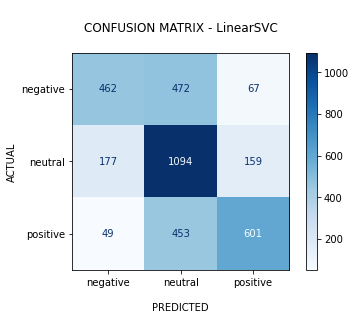

In [14]:
data = confusion_matrix(test['sentiment'], prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.ylabel('ACTUAL')
plt.xlabel('\nPREDICTED')
plt.title("\nCONFUSION MATRIX - LinearSVC\n");
plt.show()

In [15]:
model = XGBClassifier(objective='multi:softmax')
model.fit(train_vectors, train['sentiment'])
prediction = model.predict(test_vectors)
print(f"Test set accuracy: {accuracy_score(test['sentiment'], prediction) * 100} %\n")

Test set accuracy: 56.508205998868135 %



In [16]:
# Classification report
print('\tCLASSIFICATIION METRICS - XGBClassifier\n')
print(classification_report(test['sentiment'], prediction, target_names= ['negative', 'neutral', 'positive']))

	CLASSIFICATIION METRICS - XGBClassifier

              precision    recall  f1-score   support

    negative       0.73      0.27      0.40      1001
     neutral       0.49      0.88      0.63      1430
    positive       0.78      0.42      0.55      1103

    accuracy                           0.57      3534
   macro avg       0.67      0.53      0.53      3534
weighted avg       0.65      0.57      0.54      3534



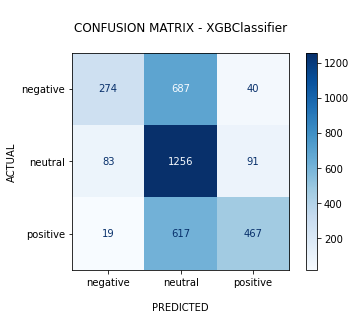

In [17]:
data = confusion_matrix(test['sentiment'], prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.ylabel('ACTUAL')
plt.xlabel('\nPREDICTED')
plt.title("\nCONFUSION MATRIX - XGBClassifier\n");
plt.show()

**Unsupervised modelling**

In [18]:
def mlp_model(layers, op_units, op_activation, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """

    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=op_units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


# 2 layer MLP
layers = 2
num_classes = 3
dropout_rate = 0.2
input_shape = train_vectors.shape[1:]

# Units and activation function for the last network layer.
activation = 'softmax'
units = num_classes

model = mlp_model(layers, units, activation, dropout_rate, input_shape, num_classes)

In [ ]:
# Compile model with learning parameters.
    loss = 'sparse_categorical_crossentropy' # for multiclass
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and test model.
    history = model.fit(
            train_vectors,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(test_vectors, train_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Test accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('Twitter_mlp_model.h5')

**Train model**

In [19]:
def train_ngram_model(train_vectors, train_labels, test_vectors, num_classes,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """

    # Create model instance.
    model = mlp_model(layers=layers,
                                  op_units=units, op_activation = 'softmax',
                                  dropout_rate=dropout_rate,
                                  input_shape=train_vectors.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    loss = 'sparse_categorical_crossentropy' # for multiclass
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and test model.
    history = model.fit(
            train_vectors,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(test_vectors, train_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Test accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('Twitter_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [20]:
train_ngram_model(train_vectors, train["sentiment"], test_vectors, 3,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2)

NameError: ignored